In [1]:
%pylab inline
import pandas as pd
import scipy.sparse as sparse
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier

Populating the interactive namespace from numpy and matplotlib


In [2]:
# DATA PLUGGIN

raw_train = pd.read_csv("train_data.csv.gz", compression="gzip", encoding="utf8")
train_data = raw_train.copy()
print("Train data shape : ", train_data.values.shape)

raw_test = pd.read_csv("test_data.csv.gz", compression="gzip", encoding="utf8")
test_data = raw_test.copy()
print("Test data shape : ", test_data.values.shape)

raw_t_target = pd.read_csv("train_target.csv")
train_target = raw_t_target.copy()
print("Train target shape : ", train_target.values.shape)


Train data shape :  (296042, 4)
Test data shape :  (1107946, 4)
Train target shape :  (5000, 2)


In [3]:
# FEATURES BUILDING

subreddits = train_data.subreddit.unique()
subreddit_size = subreddits.shape[0]
subreddit_values = array(range(subreddit_size))

subr_bij = dict(zip(subreddits, subreddit_values))


author = train_data.author.unique()
population_size = author.shape[0]
author_values = array(range(population_size))

aut_bij  = dict(zip(author,author_values))


char_set = array(list(string.printable)) # tutti i possibili caratteri
char_range = len(char_set) # segnaposto intero di tutti i possibili caratteri
char_values = array(range(1,char_range+1)) # range 1-possibli caratt

char_bij = dict(zip(char_set, char_values)) # dict access : char_bij['a'] 



In [4]:
# TARGET PREPROCESSING

# quello che faccio qui è sistemare l'ordine in cui incorrono i target a seconda dell autore
# dai dati il mio ordine è dato da train_data.author.unique()
# ho già la mia biiezione per l'ordine, che mi da l'identificativo dell autore
# aggiungo una colonna con il risultato al dataframe e la ordino secondo quesa nuova colonna
# rimuovo la colonna

print("UNSORTED:")

print(train_target.head(),"\n")

target_author = train_target.values[:,0]

identities = zeros(population_size)

for k in range(population_size):
    identities[k]=aut_bij[target_author[k]]
    
train_target['user_id'] = identities
train_target = train_target.sort_values(by=['user_id'])
train_target = train_target.drop(['user_id'],axis=1)

print("SORTED:")

print(train_target.head())

gender_target = train_target.values[:,1]

print()
print(type(gender_target))
print(gender_target.shape)
print(gender_target[0:5])

UNSORTED:
            author  gender
0     RedThunder90       0
1          Lirkmor       1
2           In0chi       0
3    ProjectGrudge       0
4  TehTurtleHermit       0 

SORTED:
             author  gender
3806    Shamus_Aran       0
2930       Riddance       1
3583  Secret_Wizard       0
2359   Penultimatum       0
1909      7-SE7EN-7       0

<class 'numpy.ndarray'>
(5000,)
[0 1 0 0 0]


In [5]:
# FEATURE : USER SPEECH
# voglio un dataframe con il nome dello user
# e un testo dove raccolgo tutti i suoi commenti
# da trasformare con tdidf in un vettore di frequenze
# poi gli applico quella distanza funzionale che ho scritto sotto

comments_collection = train_data.drop(['subreddit','created_utc'],axis=1).values

author_corpus = [''] * population_size

for j in range(comments_collection.shape[0]):

    a = comments_collection[j]
    l = aut_bij[a[0]]
    author_corpus[l]+=a[1]

In [6]:
cv = CountVectorizer()
C = cv.fit_transform(author_corpus)

tfidf = TfidfTransformer(use_idf=False)
X_train = tfidf.fit_transform(C)

print("X_train is a sparse matrix with shape: %s" % str(X_train.shape))

X_train is a sparse matrix with shape: (5000, 173211)


In [7]:
# EXPLORATORY : dovrei rimuovere degli outlier?
# chissà intanto costruisco qualcosa che mi permetta poi di farlo

spoken_words = zeros(5000)

# l'identificativo di questi tutenti è già storato nelle due liste silent e boring
silence_treshold = 5
silent = []

boring_treshold = 2500
boring = []

for j in range(5000):
    
    a = X_train[j].todense()
    
    spoken_words[j] = int(count_nonzero(a,1))
    
    if(int(count_nonzero(a,1))<silence_treshold):
        silent.append(j)
        
        
    if(int(count_nonzero(a,1))>boring_treshold):
        boring.append(j)

Silents are :  78
Boring are :  152
Rank : [ 0.0 , 8767.0 ]
4846 34
2670447
0.0030834612120477336


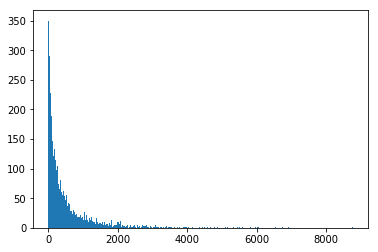

In [8]:
print("Silents are : ",len(silent))
print("Boring are : ",len(boring))

print("Rank : [",min(spoken_words),",",max(spoken_words),"]")
print(argmin(spoken_words),argmax(spoken_words))

print(X_train.count_nonzero())
print(X_train.count_nonzero()/(X_train.shape[0]*X_train.shape[1]))

plt.hist(spoken_words,bins=500)
plt.show()

[-0.96075344  0.46226835]
[1.58767129 0.81572729 0.55254125 0.41911132 0.33823828 0.28388935
 0.24481033 0.21533458 0.19229537 0.17378295]


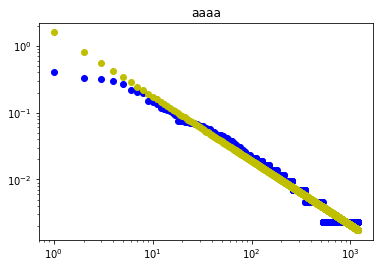

In [13]:
# ZIPF'S LAW

# posso calcolarmi gli esponenti medi della legge di zipf 
# e quando mi si presenta un caso nuovo comparare i suoi esponenti con questi

# ONE USER 
exempla = 31
vocab_len = X_train.shape[1]

user_0 = asarray( X_train[exempla].todense() ).reshape(vocab_len)

log_dense_user  = []
lin_dense_user = []

#print(vocab_len)

for j in range( vocab_len ):
    
    # se devo fare il log-log tanto vale che ci metta già dentro il log
    if(user_0[j]!=0):
        lin_dense_user.append(user_0[j])
        
lin_dense_user = array (lin_dense_user )
lin_dense_user = numpy.sort( lin_dense_user )
lin_dense_user = numpy.flip( lin_dense_user )

x = range(1,lin_dense_user.shape[0]+1)
y = lin_dense_user

# - - - F I T - - -
# BASTAVA INVERTIRE BETA E ALPHAAAAAAAAA
coeff = numpy.polyfit(numpy.log(x), numpy.log(y), 1)
beta, alpha = coeff[0],coeff[1]

# hypotesis

w =  exp(alpha)*(pow(x,beta)) 
print( coeff ) 
print( w[0:10] ) 

# - - - P L O T - - -
      
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xscale("log")
ax.set_yscale("log")
#ax.set_xlim(1e-3, 1e4) # <-- check this as pointed out by @tillsten
#ax.set_ylim(1e-1, 1e3) # <--
#ax.set_aspect(1)
ax.set_title("aaaa")

#ax.plot(x,lin_dense_user,'bo')
ax.plot(x,lin_dense_user,'bo',x,w,'yo')


In [118]:
print(X_train[0].shape)
print(asarray( X_train[k].todense() ).reshape(vocab_len))

(1, 173211)
[0. 0. 0. ... 0. 0. 0.]


In [19]:
# MUCH USER

pop_size  = X_train.shape[0]
vocab_len = X_train.shape[1]

zipf_coeff = []
skip = []
for k in range(pop_size):
    
    user_0 = asarray( X_train[k].todense() ).reshape(vocab_len)
    
    dense_user = []

    for j in range( vocab_len ):
        if(user_0[j]!=0):
            dense_user.append(user_0[j])
            
    # rimuovo utenti con troppo poco parlato        
    if(len(dense_user)>2):
    
        dense_user = array (dense_user )
        dense_user = numpy.sort( dense_user )
        dense_user = numpy.flip( dense_user )
    
        words = dense_user.shape[0]+1

        x = range(1,words)
        y = dense_user
    
    # --- log-log fit ---
    # ogni utente ha associati i due coefficienti della legge di zipf
        zipf_coeff.append( numpy.polyfit(numpy.log(x), numpy.log(y), 1) )
    else:
        skip.append(k)

zipf_coeff = array(zipf_coeff)   
#print(zipf_coeff.shape)

In [30]:
print(zipf_coeff.shape)
# skip mi dirà dove andare a rimuovere 
# gli utenti taciturni
print(len(skip))
print(skip)

(4967, 2)
33
[1743, 1786, 2426, 2729, 2841, 3127, 3243, 3617, 3776, 3818, 3871, 3886, 4039, 4082, 4134, 4181, 4182, 4204, 4294, 4371, 4379, 4441, 4631, 4657, 4725, 4743, 4748, 4766, 4846, 4894, 4915, 4940, 4977]


In [29]:
# skip mi serve solo per il target, 
# per come sono andato a costruire coeff non devo toglierci niente
zipf_gender = delete(gender_target, obj = skip)

print(zipf_gender.shape)


(4967, 2)
(4967,)


/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  """Entry point for launching an IPython kernel.


(-1, 1)

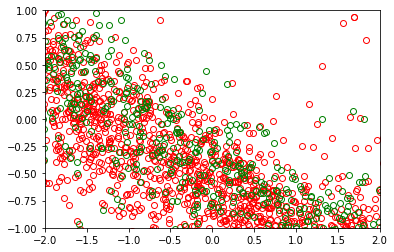

In [41]:
c0 = zipf_gender==0
c1 = zipf_gender==1

#zipf_coeff[:,0] = (zipf_coeff[:,0]-zipf_coeff[:,0].mean())/var(zipf_coeff[:,0])
#zipf_coeff[:,1] = (zipf_coeff[:,1]-zipf_coeff[:,1].mean())/var(zipf_coeff[:,1])

plot(zipf_coeff[:,0][c0], zipf_coeff[:,1][c0], 'o', mec='r', mfc='none')
plot(zipf_coeff[:,0][c1], zipf_coeff[:,1][c1], 'o', mec='g', mfc='none')

#plot(zipf_coeff[:,0], zipf_coeff[:,1],'bo')

xlim(-2,2)
ylim(-1,1)
# AHAHAHAHA POI POSSO FARE CLASSIFICAZIONE/REGRESSIONE SUI DUE ESPONENTI DELLA LEGGE DI ZIPF
# CIAOOOOOOO

In [126]:
# posso provare a fare un plot radiale di sta roba e vedere se si separano le popolazioni

<class 'numpy.ndarray'>
(5000,)


In [9]:
# --- I N T E R E S T S   A N D   S U B R E D D I T S ---

# --- posso creare una matrice 'sparsa' in cui vedo chi partecipa e quanto a quale discussione
# devo mappare il sub_dataframe con utente e subr di ciascun commento nella matrice di attività

interests = train_data.drop(['created_utc','body'],axis=1).values

interests_matrix = zeros(population_size*subreddit_size)
interests_matrix = interests_matrix.reshape(population_size,subreddit_size)

print(interests_matrix.shape[0])

for j in range(interests.shape[0]):
    
    a = interests[j]
    k = aut_bij[a[0]]
    l = subr_bij[a[1]]
    interests_matrix[k,l]+=1
    
# ogni riga rappresenta la partecipazione di un utente ad un reddit
print("interests_matrix is a sparse matrix with shape: ", interests_matrix.shape)
print("\n",interests_matrix[0:10,0:10])

5000
interests_matrix is a sparse matrix with shape:  (5000, 3468)

 [[  4.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   2.   0.   0.   0.   0.   0. 116.   0.   0.]
 [  0.   0.   5.   0.   0.   0.   0.  65.   7.   0.]
 [  0.   1.   0.   3.   4.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.  34.   0.   0. 477.   0.   0.]
 [  0.   0.   0.   0.   0. 105.   3.   7.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   2.   0.   0.   0.]
 [  0.   0.   0.   0.   1.   0.   0. 128.   0.   0.]
 [  0.   2.   0.   0.   0.   0.   0.  20.   1.   0.]
 [  0.   0.   0.   0.   1.   0.   0.   0.   0.  98.]]


In [19]:
# fallo, ma solo se fai validation

vt = 4000 # validation treshold

subr_train = interests_matrix[0:vt]
subr_valid = interests_matrix[vt:population_size]

target_subr_train = gender_target[0:vt]
target_subr_train=target_subr_train.astype('int')

target_subr_valid = gender_target[vt:5000]
target_subr_valid=target_subr_valid.astype('int')


print(subr_train.shape,subr_valid.shape)
print(target_subr_train.shape,target_subr_valid.shape)

(4000, 3468) (1000, 3468)
(4000,) (1000,)


[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30.]


In [36]:
from sklearn import metrics
from sklearn import model_selection

In [ ]:
# SE FAI CROSS VALIDATION METTI TUTTI I DATI NON SERVE CHE FAI LA PARTIZIONE PRIMA

In [45]:
neighbours = linspace(21, 30, num=10)
print(neighbours)

[21. 22. 23. 24. 25. 26. 27. 28. 29. 30.]


In [12]:
# - - -   F E A T U R E   :   N A M E   - - -

# posso mettere anche in relazione lo user e il suo nome:
# vedo quale utente ha il nome più lungo e posso fare anche pca
# da li poi una rete neurale piccola, con iperparametri basati su pca

# voglio la stringa di lunghezza massima
sizes = zeros(population_size)

for j in range(population_size):
    sizes[j]=len(author[j])
    
print("Longhest string is : ", max(sizes),"at position",argmax(sizes))
print("He/she is:", author[argmax(sizes)])

Longhest string is :  20.0 at position 15
He/she is: irrational_abbztract


In [13]:
ambient_dim = int(max(sizes))
plateaux = zeros(ambient_dim)

In [14]:
# converto i nomi in vettori nello spazio dim20

def from_name_to_vector(name):
    
    name_dim = len(name)-1
    name = array(list(name))
    
    num_name = zeros(ambient_dim)
    
    for j in range(ambient_dim):
        
        if j<name_dim:
            num_name[j] = char_bij[ name[j] ]
        else:
            num_name[j] = 0
            
    return num_name

In [17]:
# DATA MATRIX

name_matrix = [plateaux for i in range(population_size)]
# mi costruisco la data matrix, poi da normalizzare con non negative matrix factorization

for j in range(population_size):
        name_matrix[j]=from_name_to_vector(author[j])
        
name_matrix=array(name_matrix)

In [ ]:
neighbours = linspace(1, 30, num=20)

test_score = []

for n in neighbours:
    
    subr_clf = KNeighborsClassifier( int(n) )
    subr_clf.fit(subr_train,target_subr_train)
    
    prediction = subr_clf.predict(subr_valid)
    
    #mse = metrics.mean_squared_error(y_test, y_train)
    #train_score.append(mse)
    
    cv_val = model_selection.cross_val_score(subr_clf, subr_train,target_subr_train, cv=5)
    test_score.append(cv_val.mean())
    
k = np.argmax(test_score)

print(neighbour[k],test_score[k])
#winner = degrees[np.argmax(test_scores)]

plot(neighbours,test_score,"bo")
#plot(neighbours[k],test_score[k],"yo")

prediction = subr_clf.predict(subr_valid)

difference = zeros(1000)
for j in range(1000):
    
    difference[j] = abs(prediction[j]-target_subr_valid[j])
    
print(dot(prediction,ones(1000)))
 